# German News Text Topic Classification

## 1. Initial Setup and Dependency Installation

In [199]:
# Import necessary libraries

# Standard library imports
import os
import glob

# Data manipulation and analysis
import pandas as pd
import numpy as np 

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Machine Learning - Preprocessing and model training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Machine Learning - Model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the necessary NLTK datasets are downloaded
nltk.download('punkt')  # Tokenizer for splitting text into tokens
nltk.download('stopwords')  # Common words that typically do not carry unique meanings

[nltk_data] Downloading package punkt to /Users/yu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Preprocessing - „Freiheitskampf“

In [200]:
# Function to load text files from a specified path
def load_texts(path, label):
    texts = []
    for filename in glob.glob(os.path.join(path, '*.txt')):
        with open(filename, 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return pd.DataFrame({'text': texts, 'label': label})

# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    words = word_tokenize(text, language='german')
    # Load German stopwords
    stop_words = set(stopwords.words('german'))
    # Remove stopwords and only keep alphabetic characters, then perform stemming
    # Initialize German stemmer
    stemmer = SnowballStemmer('german')
    words = [stemmer.stem(word.lower()) for word in words if word.isalpha() and word.lower() not in stop_words]
    # Return the processed text
    return ' '.join(words)

print('ok')

ok


In [201]:
# Set paths
economy_path = '/Users/yu/Desktop/TextClassification/Data/Wirtschaftstexte'
non_economy_base_path = '/Users/yu/Desktop/TextClassification/Data/Nicht-Wirtschaftstexte'

# Load economic texts
economy_texts = load_texts(economy_path, 'economy')

# Load non-economic texts (politics, arts, sports)
categories = ['Politiktexte', 'Kunsttexte', 'Sporttexte']
non_economy_texts = pd.concat([load_texts(os.path.join(non_economy_base_path, category), 'noneconomy') for category in categories])

# Merge economic and non-economic texts
data = pd.concat([economy_texts, non_economy_texts], ignore_index=True)

# Preprocess text data
data['text'] = data['text'].apply(preprocess_text)

print('ok')

ok


## Model Training and Evaluation

In [202]:
# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.25, min_df=3, ngram_range=(1,1), use_idf=True, sublinear_tf=True)

# Feature extraction
X = tfidf.fit_transform(data['text'])
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Naive Bayes classifier, using the best alpha parameter obtained from grid search
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)

# Perform predictions
y_pred = model.predict(X_test)

# Output evaluation results
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

     economy       0.94      0.88      0.91        17
  noneconomy       0.83      0.91      0.87        11

    accuracy                           0.89        28
   macro avg       0.89      0.90      0.89        28
weighted avg       0.90      0.89      0.89        28

Accuracy: 0.8928571428571429


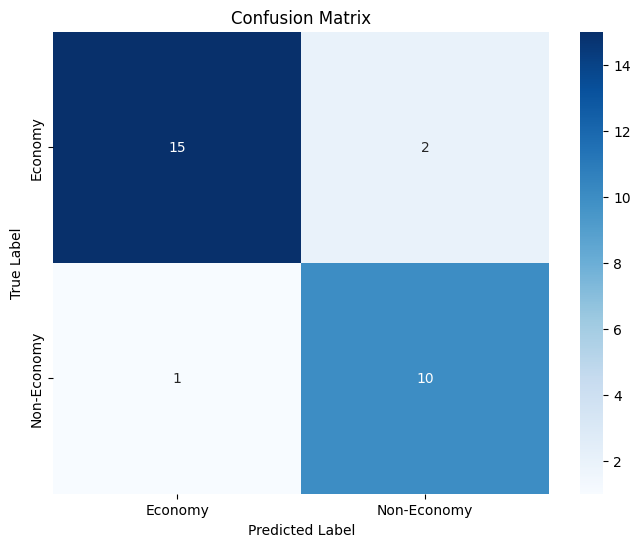

In [203]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set up the plot
plt.figure(figsize=(8, 6))

# Use Seaborn to create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Economy', 'Non-Economy'], yticklabels=['Economy', 'Non-Economy'])

# Add title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the plot
plt.show()

Cross-Validation Accuracy: 0.7582417582417582
Average Cross-Validation Accuracy: 75.91%


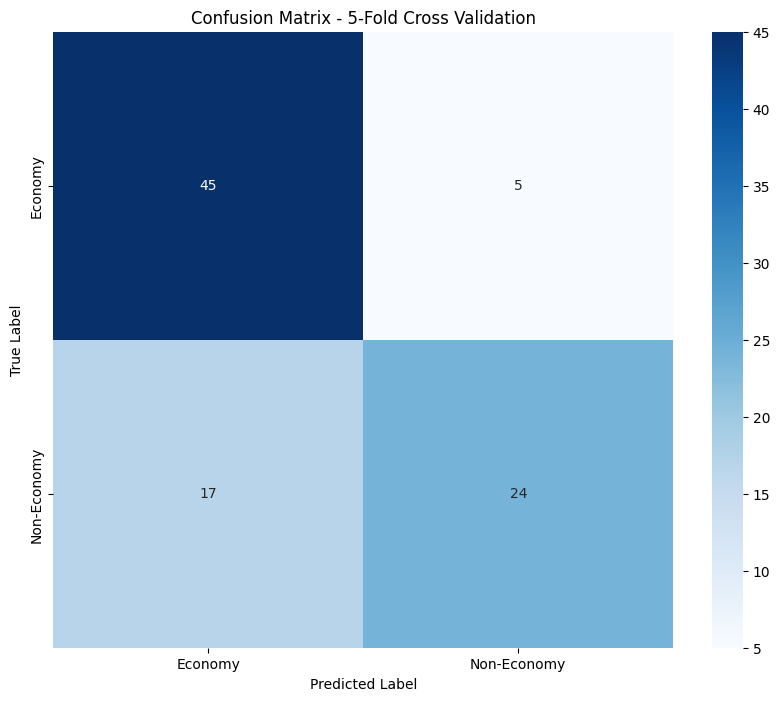

In [216]:
# Assuming X, y are your features and labels for the entire dataset
model = MultinomialNB()

# Use 5-fold cross-validation to generate predicted categories for the entire dataset
y_pred_cv = cross_val_predict(model, X, y, cv=5)

# Calculate the confusion matrix for cross-validation predictions
conf_matrix_cv = confusion_matrix(y, y_pred_cv)
print("Cross-Validation Accuracy:", accuracy_score(y, y_pred_cv))

# Calculate average cross-validation accuracy
accuracy_scores_cv = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Average Cross-Validation Accuracy: {:.2f}%".format(np.mean(accuracy_scores_cv) * 100))

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cv, annot=True, fmt='d', cmap='Blues', xticklabels=['Economy', 'Non-Economy'], yticklabels=['Economy', 'Non-Economy'])
plt.title('Confusion Matrix - 5-Fold Cross Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

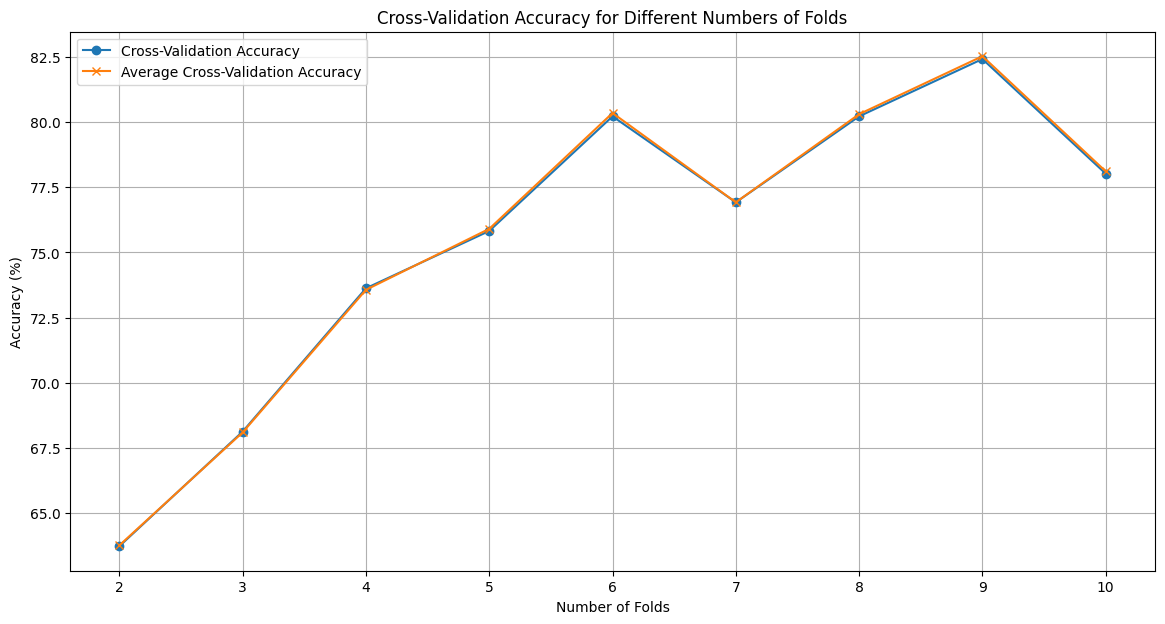

In [217]:
# Initialize lists to store the cross-validation accuracies
cv_accuracies = []
average_cv_accuracies = []

# Loop through numbers 2 to 10 for cross-validation
for cv in range(2, 11):
    # Generate cross-validated estimates for each input data point
    y_pred = cross_val_predict(model, X, y, cv=cv)
    
    # Calculate accuracy for each fold
    cv_accuracy = accuracy_score(y, y_pred)
    cv_accuracies.append(cv_accuracy)
    
    # Calculate average cross-validation accuracy
    average_cv_accuracy = np.mean(cross_val_score(model, X, y, cv=cv, scoring='accuracy'))
    average_cv_accuracies.append(average_cv_accuracy)

# Convert lists to numpy arrays for easier plotting
cv_accuracies = np.array(cv_accuracies)
average_cv_accuracies = np.array(average_cv_accuracies)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(range(2, 11), cv_accuracies * 100, label='Cross-Validation Accuracy', marker='o')
plt.plot(range(2, 11), average_cv_accuracies * 100, label='Average Cross-Validation Accuracy', marker='x')
plt.title('Cross-Validation Accuracy for Different Numbers of Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

## Model Optimisation

In [182]:
# Set the range of parameters to test
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__min_df': (1, 2, 3),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # Test different n-gram ranges
    'clf__alpha': (1e-2, 1e-3, 1e-4)  # Test different alpha values
}

# Create a pipeline that includes the TF-IDF step and the classifier step
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True)),
    ('clf', MultinomialNB()),
])

# Perform grid search
grid_search = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
grid_search.fit(data['text'], y)

# View the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'clf__alpha': 0.001, 'tfidf__max_df': 0.25, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}


## Tests on larger datasets - 10k German News Articles

Best alpha: {'alpha': 0.1}
Best cross-validation score: 0.7425258649078292
               precision    recall  f1-score   support

         Etat       0.96      0.52      0.67        85
       Inland       0.72      0.83      0.77       103
International       0.78      0.85      0.81       148
       Kultur       0.70      0.86      0.77        57
     Panorama       0.75      0.75      0.75       167
        Sport       0.98      0.97      0.98       115
          Web       0.90      0.86      0.88       154
   Wirtschaft       0.76      0.82      0.79       152
 Wissenschaft       0.87      0.72      0.79        47

     accuracy                           0.81      1028
    macro avg       0.82      0.80      0.80      1028
 weighted avg       0.82      0.81      0.81      1028

Accuracy: 0.8103112840466926
Average Cross-Validation Accuracy: 72.86%


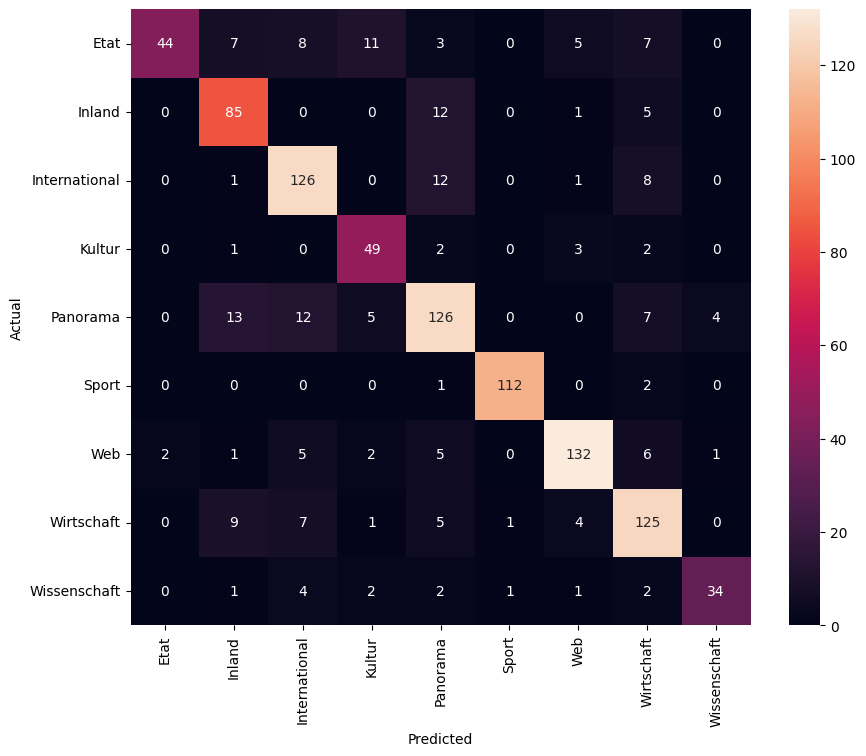

In [218]:
# Load and parse data
file_path = '/Users/yu/Desktop/TextClassification/10kGNAD/articles.csv'
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

parsed_data = []
for line in lines:
    parts = line.strip().split(';', 1)
    if len(parts) == 2:
        label, text_with_title = parts
        text_with_title = text_with_title.replace(';', ' ')
        parsed_data.append([label, text_with_title])

df = pd.DataFrame(parsed_data, columns=['label', 'text'])

# Text preprocessing
def preprocess_text(text):
    words = word_tokenize(text, language='german')
    stop_words = set(stopwords.words('german'))
    stemmer = SnowballStemmer('german')
    words = [stemmer.stem(word.lower()) for word in words if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(words)

df['text'] = df['text'].apply(preprocess_text)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_df=0.1, min_df=25, ngram_range=(1, 1), use_idf=True, sublinear_tf=True)
X = tfidf.fit_transform(df['text'])
y = df['label']

# Set up GridSearchCV to find the best alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(X, y)

# Print the best alpha and the best score from cross-validation
print("Best alpha:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate using the best model
best_model = grid_search.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Output performance report
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
accuracy_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Average Cross-Validation Accuracy: {:.2f}%".format(np.mean(accuracy_scores) * 100))

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=pd.unique(df['label']), yticklabels=pd.unique(df['label']))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [191]:
# Create a pipeline with TF-IDF vectorizer and Naive Bayes classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True)),
    ('clf', MultinomialNB())
])

# Define the parameter grid to search
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.01, 0.1, 1]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=52, verbose=1, n_jobs=-1)

# Assuming 'df' is your DataFrame and 'text' and 'label' are column names
X = df['text']
y = df['label']

# Fit GridSearchCV
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Optionally, evaluate the best model on test data or further analysis
# Example: Using the best estimator directly
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)  # or on a separate test set if available

# Print out the classification report for the best model
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters:  {'clf__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score: 0.75
               precision    recall  f1-score   support

         Etat       0.98      0.86      0.91       668
       Inland       0.87      0.92      0.90      1015
International       0.92      0.95      0.93      1511
       Kultur       0.91      0.94      0.93       539
     Panorama       0.92      0.90      0.91      1678
        Sport       0.99      0.97      0.98      1201
          Web       0.95      0.91      0.93      1677
   Wirtschaft       0.88      0.94      0.91      1411
 Wissenschaft       0.95      0.93      0.94       573

     accuracy                           0.93     10273
    macro avg       0.93      0.92      0.93     10273
 weighted avg       0.93      0.93      0.93     10273

